# NASA Defects - Model Building

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier



from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "US_Churn"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = False
SEED = 1612

In [2]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")
        d = "/content/gdrive/MyDrive/datasets"
        if not os.path.isdir(d): os.makedirs(d)
        if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
    if COLAB:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
    else:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Dataset

In [3]:
df = pd.read_csv(f"{ROOT}/data/pc2.csv")
print(df.shape)
df.head(5)

(933, 37)


,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defects
0,1.0,4.0,7.0,24.0,0.0,1.0,0.13,0.0,0.0,1.0,1.00,6.0,1.0,0.0,1.0,0.0,17.88,7.43,986.77,0.04,34.0,0.13,54.82,132.83,1.0,0.0,0.0,7.0,0.03,13.0,21.0,7.0,8.0,34.0,96.88,8.0,False
1,1.0,1.0,11.0,3.0,0.0,1.0,0.08,0.0,0.0,1.0,1.00,2.0,1.0,0.0,1.0,0.0,42.62,7.81,2598.31,0.11,77.0,0.13,144.35,332.79,1.0,0.0,0.0,3.0,0.06,29.0,48.0,13.0,7.0,17.0,93.33,12.0,False
2,5.0,1.0,9.0,10.0,6.0,3.0,0.25,2.0,3.0,2.0,0.67,9.0,3.0,1.0,3.0,3.0,15.53,18.90,5545.97,0.10,64.0,0.05,308.11,293.44,1.0,2.0,3.0,8.0,0.13,27.0,37.0,10.0,14.0,24.0,86.36,12.0,False
3,1.0,0.0,3.0,5.0,0.0,1.0,0.25,0.0,0.0,1.0,1.00,1.0,1.0,0.0,1.0,1.0,20.84,3.94,323.05,0.03,21.0,0.25,17.95,82.04,1.0,0.0,0.0,2.0,0.09,9.0,12.0,8.0,7.0,11.0,88.89,4.0,False
4,3.0,0.0,1.0,0.0,4.0,2.0,1.00,2.0,2.0,1.0,0.50,7.0,1.0,0.0,1.0,3.0,11.42,6.67,507.65,0.03,20.0,0.15,28.20,76.15,0.5,1.0,2.0,7.0,0.50,10.0,10.0,6.0,8.0,4.0,50.00,2.0,False


## Target and Features

In [4]:
target = "defects"
features = [c for c in df.columns if c not in target]

num_features = len(features)

print(f"Traget: {target}")
print(f"Features: {features}")

Traget: defects
Features: ['BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'CYCLOMATIC_DENSITY', 'DECISION_COUNT', 'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MAINTENANCE_SEVERITY', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES', 'PERCENT_COMMENTS', 'LOC_TOTAL']


### Check target values

In [5]:
df[target].value_counts(normalize=True)

False    0.975348
True     0.024652
Name: defects, dtype: float64

#### Comments
- From the relative frequencies above we can see clearly that the dataset is unbalanced.
- We will attempt to use a Synthetic Minority Oversampling Technique (SMOTE) to balance out the dataset later on.

## Feature Engineering

### Normalising Features

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(df.loc[:,features].values)

df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled[target] = df[target]

df_scaled.shape

(933, 37)

### Feature Selection

In [7]:
print("Number of features starting:", len(features))

Number of features starting: 36


Optimal number of features : 7


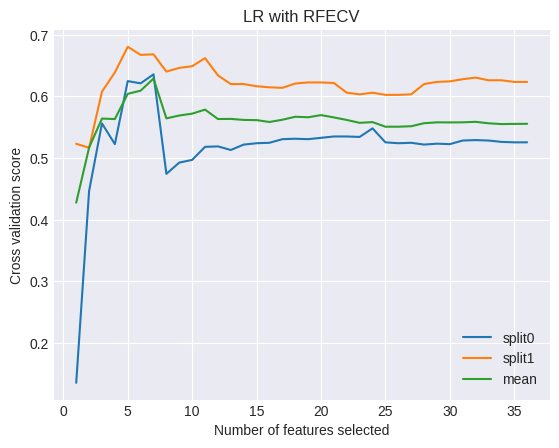

In [8]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "ADA": AdaBoostClassifier(),
    "RFC": RandomForestClassifier()
}

name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(4), scoring="roc_auc")
rfecv.fit(df_scaled[features], df_scaled[target])
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [9]:
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['LOC_CODE_AND_COMMENT',
 'DECISION_COUNT',
 'DESIGN_DENSITY',
 'ESSENTIAL_COMPLEXITY',
 'HALSTEAD_CONTENT',
 'MODIFIED_CONDITION_COUNT',
 'NORMALIZED_CYLOMATIC_COMPLEXITY']

#### Comments
- Using logistic regression and recursive feature elimination with cross-validation we narrow down the number of optimal features  to 7.   
    - Increasing the StratfiedKFold would yield more definite results if the data set was larger, however since the dataset is small we will stick to a lower number ie.4 so that the data isnt split up too many times.
- Feature importance
    - LOC_CODE_AND_COMMENT - this feature refers to the total Lines Of Code (LOC) that contain code and comments, comments are typically used to either suggest potential problem areas in code, a significant presence or no presence could be a good indicator.
    - DECISION_COUNT - this feature keeps track of  the number of decision points in the code (places where the code execution diverts based on conditions). These are often confusing combinations of statements that can be easilyy overlooked so a  high count could indicate a higher possibility of oversight that could in turn cause issues.
    - DESIGN_DENSITY - this  feature measures how many design structures there are compared to how many code statements and expressions there are. A more complex design may be indicated by a larger design density, which could result in more problems.
    - ESSENTIAL_COMPLEXITY - this feature counts the number of crucial choices that must be made in order to comprehend the code in order to calculate complexity. More essential complexity can suggest a larger chance of defects, much like the decision count can.
    - HALSTEAD_CONTENT - tfeature that assesses the code's content by counting the number of distinct operators and operands used. More content may suggest more sophisticated code, and because complex code is more difficult to understand, it may produce more flaws.
    - MODIFIED_CONDITION_COUNT - this feature  keeps track of the variety of distinct decision-making processes that rely on modified variables. This, like the decision count, can show contradictory logical combinations and, when combined with variables, can result in a greater overview of potential issue states.
    - NORMALIZED_CYCLOMATIC_COMPLEXITY - this feature  counts the number of pathways through the code graph to determine how difficult the code logic is. Greater cyclomatic complexity may be a sign of convoluted or complex control flow, which can be more problematic because it can be challenging to analyse and test.
    
    
- It's crucial to remember that each of these features takes into account a different component of software development, such as complexity and design, and aims to identify unique measurements that could identify more error-prone code.

## Showcasing SMOTE

### Imports for SMOTE

In [10]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

### Create a synthetic binary classification dataset

In [11]:
X, y = make_classification(n_samples=933, n_features=len(features_selected), n_redundant=0, n_clusters_per_class=1, weights=[0.975], flip_y=0, random_state=SEED)

### Summarize class distribution

In [12]:
counter = Counter(df_scaled[target])
print(counter)

Counter({False: 910, True: 23})


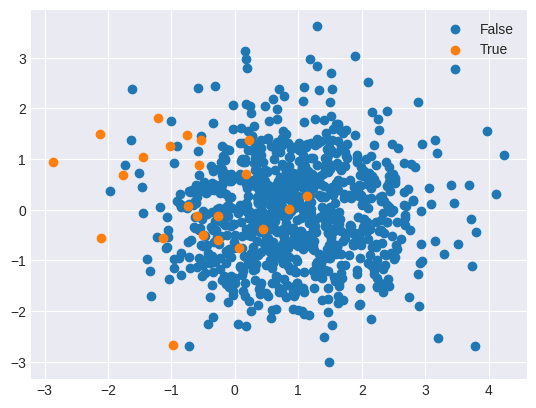

In [13]:
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### Define pipeline

In [14]:
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over),('u',under)]
pipeline = Pipeline(steps=steps)

#### Comments
- As seen from the plot above our target values are heavily imbalanced which in turn would provide skewed results.
- We will attempt to balance out the dataset by oversampling the minorty class and undersampling the majority class
- Using smote we can create synthetic instances of the minorty class to balance out the data, we use a 0.3 sampling strategy which is the desird ratio of the majority class over the minority.
- We can also use RandomUnderSampler to under sample the majority class by randomly picking samples.

### Transform the dataset

In [15]:
X, y = pipeline.fit_resample(X, y)

### Summarize the new class distribution

In [16]:
counter = Counter(y)
print(counter)

Counter({0: 546, 1: 273})


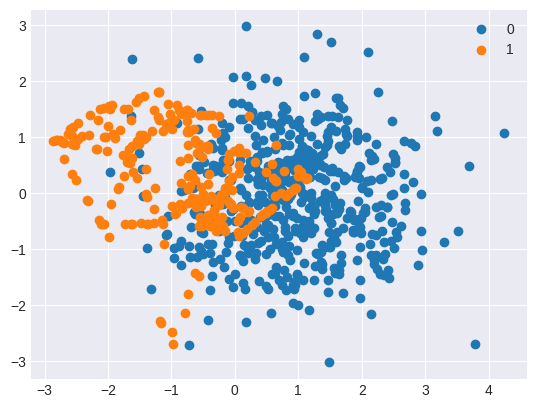

In [17]:
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

#### Comments
-  Using a synthetic classification dataset we can clearly see that  after refiting our model using or over and under sampling pipeline there is quite a few more plots for each class and the data seems somewhat more balanced

Note: a synthetic classification was used to show the effects of SMOTE and RUS as it the graphs were more clear, although the specification for the synthetic classification was configured to match the cleaned NASA dataset.

## Using SMOTE and RUS to balance out our dataset

In [18]:
X_smote, y_smote = pipeline.fit_resample(df_scaled[features_selected],df_scaled[target])

/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


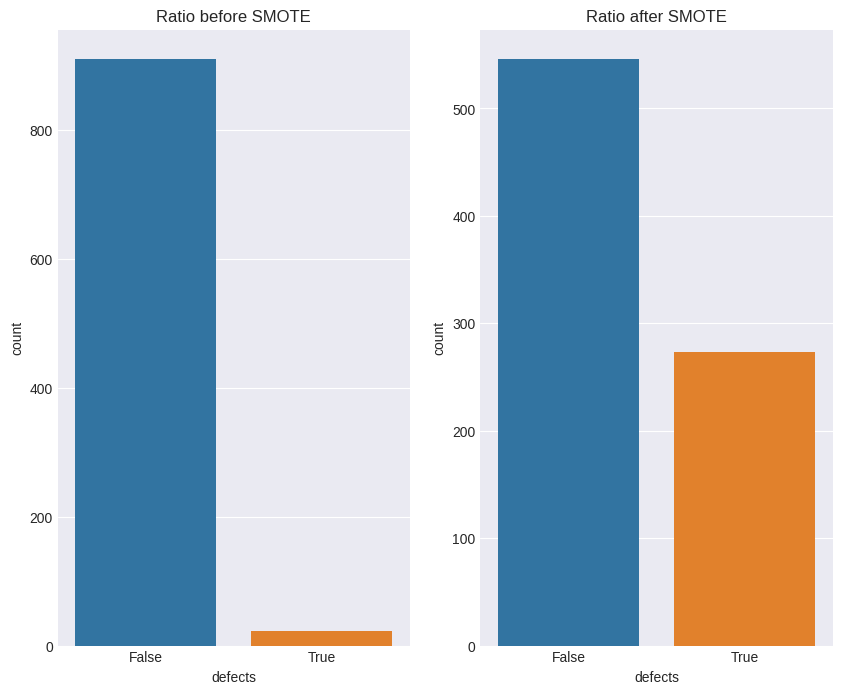

Counter({False: 546, True: 273})

In [19]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(df_scaled[target])
plt.title('Ratio before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Ratio after SMOTE')
plt.show()
Counter(y_smote)

#### Comments
- We can clearly see the effect of our balancing pipeline on the graphs above.
- Before our pipeline we had 933 cases, roughtly 910 for the false class and 23 for the true class
- After oversampling the minority and undersampling majoruty classes we have 546 for the false class and 273 for the true class
- Although theyre not exactly balanced 1:1 they are much closer than they were before and should give better results

Note: When balancing out an imbalanced dataset, we typically aim to increase the representation of the minority class to a level that is sufficient for the model to learn the relevant patterns and make accurate predictions. However, we generally do not aim for an exact 1:1 balance between the classes, as this could potentially lead to overfitting and reduced model performance.

## Model Selection

In [20]:
def train_models(features,target):
    best = {'name':None, 'mean':0}
    
    for name,model in models.items():
    
        scores = cross_val_score(model, features, target, scoring='roc_auc', cv=10)
        mean = scores.mean()
        std = scores.std()
        
        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")
    
        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) PR_AUC = {best['mean']:.2%}" )

### Training models

#### Training on cleaned dataset

In [21]:
train_models(df_scaled[features],df_scaled[target])


Model LR
	CV scores: 0.55, 0.44, 0.53, 0.57, 0.26, 0.90, 0.36, 0.49, 0.34, 0.36
	mean=48.10% std=0.1706

Model DT
	CV scores: 0.81, 0.48, 0.46, 0.49, 0.47, 0.73, 0.49, 0.73, 0.48, 0.49
	mean=56.36% std=0.1288

Model DT(max_depth=3)
	CV scores: 0.66, 0.77, 0.54, 0.61, 0.48, 0.72, 0.48, 0.73, 0.63, 0.46
	mean=60.91% std=0.1066

Model KNN
	CV scores: 0.96, 0.62, 0.46, 0.72, 0.47, 0.43, 0.45, 0.43, 0.45, 0.44
	mean=54.31% std=0.1672

Model SVC
	CV scores: 0.74, 0.81, 0.62, 0.95, 0.50, 0.97, 0.49, 0.85, 0.75, 0.77
	mean=74.41% std=0.1561

Model ADA
	CV scores: 0.87, 0.09, 0.63, 0.60, 0.43, 0.76, 0.63, 0.95, 0.43, 0.31
	mean=57.02% std=0.2487

Model RFC
	CV scores: 0.82, 0.84, 0.45, 0.59, 0.23, 0.73, 0.54, 0.81, 0.53, 0.42
	mean=59.51% std=0.1918

Best Performing Model SVC with (mean CV of) PR_AUC = 74.41%


#### Training on cleaned and balanced dataset

In [22]:
train_models(X_smote,y_smote)


Model LR
	CV scores: 0.77, 0.65, 0.69, 0.73, 0.63, 0.66, 0.68, 0.74, 0.60, 0.78
	mean=69.42% std=0.0574

Model DT
	CV scores: 0.72, 0.86, 0.94, 0.86, 0.91, 0.92, 0.89, 0.86, 0.94, 0.94
	mean=88.36% std=0.0607

Model DT(max_depth=3)
	CV scores: 0.82, 0.82, 0.89, 0.92, 0.80, 0.87, 0.76, 0.88, 0.85, 0.89
	mean=84.99% std=0.0467

Model KNN
	CV scores: 0.94, 0.86, 0.94, 0.98, 0.93, 0.90, 0.92, 0.97, 0.92, 0.94
	mean=92.97% std=0.0313

Model SVC
	CV scores: 0.82, 0.79, 0.80, 0.81, 0.80, 0.82, 0.77, 0.81, 0.72, 0.89
	mean=80.15% std=0.0413

Model ADA
	CV scores: 0.75, 0.93, 0.91, 0.93, 0.92, 0.93, 0.93, 0.94, 0.90, 0.93
	mean=90.79% std=0.0538

Model RFC
	CV scores: 0.89, 0.97, 1.00, 0.98, 0.99, 0.98, 0.98, 0.99, 0.99, 0.99
	mean=97.68% std=0.0284

Best Performing Model RFC with (mean CV of) PR_AUC = 97.68%


#### Comments
- Runing the traing model function twice to compare the results achieved from a balanced and unbalanced dataset shows the effect and unbalanced dataset can have:
    - The unbalanced dataset best performing model was Support Vector Classification (SVC) and it mean was only 74.41%
    - The balanced dataset best performing model was Random Forest Classifier (RFC) and its mean was 97.83% .
    - The balanced dataset bested the unbalanced dataset PR AUC metric by nearly 24% 